# MNIST

Hands-on exercises:

* 1. A classifier for the MNIST dataset that achieves over 97% accuracy on the test set.
* 2. A function that can shift an MNIST image in any direction by one pixel, then train a model in the expanded training set (data augmentation).

## 1. Imports

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets        import fetch_openml
from sklearn.preprocessing   import StandardScaler
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics         import accuracy_score
from scipy.ndimage.interpolation import shift

## 2. Getting the data

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
mnist['DESCR']

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [5]:
mnist['details']

{'id': '554',
 'name': 'mnist_784',
 'version': '1',
 'format': 'ARFF',
 'creator': ['Yann LeCun', 'Corinna Cortes', 'Christopher J.C. Burges'],
 'upload_date': '2014-09-29T03:28:38',
 'language': 'English',
 'licence': 'Public',
 'url': 'https://www.openml.org/data/v1/download/52667/mnist_784.arff',
 'file_id': '52667',
 'default_target_attribute': 'class',
 'tag': ['AzurePilot',
  'OpenML-CC18',
  'OpenML100',
  'study_1',
  'study_123',
  'study_41',
  'study_99',
  'vision'],
 'visibility': 'public',
 'minio_url': 'http://openml1.win.tue.nl/dataset554/dataset_554.pq',
 'status': 'active',
 'processing_date': '2020-11-20 20:12:09',
 'md5_checksum': '0298d579eb1b86163de7723944c7e495'}

In [6]:
X, y = mnist['data'], mnist['target']

In [7]:
print(f"X shape: {X.shape}\ny shape: {y.shape}")

X shape: (70000, 784)
y shape: (70000,)


In [8]:
X.dtype

dtype('float64')

In [9]:
y.dtype

dtype('O')

In [10]:
y = y.astype(np.uint8)

## 3. Exploring the data structure

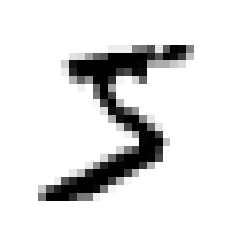

In [11]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [12]:
y[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

## 4. Test set

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 5. Preparing the data for ML

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

## 6. Model selection and training

In [15]:
kn_clf = KNeighborsClassifier()
kn_clf.fit(X_scaled, y_train)

KNeighborsClassifier()

In [16]:
cross_val_score(kn_clf, X_scaled, y_train, cv=3, scoring='accuracy')

array([0.9376, 0.9411, 0.9424])

## 7. Tuning the model

In [17]:
par_distribution = [{
                     'weights': ['uniform'],
                     'n_neighbors': np.arange(1, 15, 1)
                     },
                     {
                     'weights': ['distance'],
                     'n_neighbors': np.arange(1, 15, 1)
                     }]

grid_search = RandomizedSearchCV(kn_clf, param_distributions=par_distribution, n_iter=10,
                                 scoring='accuracy', return_train_score=True, random_state=0)

In [18]:
grid_search.fit(X_scaled, y_train)

RandomizedSearchCV(estimator=KNeighborsClassifier(),
                   param_distributions=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                         'weights': ['uniform']},
                                        {'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                         'weights': ['distance']}],
                   random_state=0, return_train_score=True, scoring='accuracy')

In [20]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.9427833333333332 {'weights': 'uniform', 'n_neighbors': 3}
0.9408 {'weights': 'distance', 'n_neighbors': 9}
0.9422333333333335 {'weights': 'distance', 'n_neighbors': 1}
0.9465166666666667 {'weights': 'distance', 'n_neighbors': 4}
0.9405000000000001 {'weights': 'uniform', 'n_neighbors': 6}
0.9360333333333333 {'weights': 'uniform', 'n_neighbors': 12}
0.9388500000000001 {'weights': 'distance', 'n_neighbors': 11}
0.9347333333333333 {'weights': 'uniform', 'n_neighbors': 14}
0.94235 {'weights': 'distance', 'n_neighbors': 7}
0.9389166666666666 {'weights': 'distance', 'n_neighbors': 12}


In [22]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [72]:
# fine-tune the search
par_distribution ={
    'weights': ['distance'],
    'n_neighbors': np.arange(3, 6, 1)
}

fine_grid_search = GridSearchCV(kn_clf, param_grid=par_distribution, 
                               scoring='accuracy', return_train_score=True, n_jobs=3)
fine_grid_search.fit(X_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=3,
             param_grid={'n_neighbors': array([3, 4, 5]),
                         'weights': ['distance']},
             return_train_score=True, scoring='accuracy')

In [73]:
cvres = fine_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.9442833333333335 {'n_neighbors': 3, 'weights': 'distance'}
0.9465166666666667 {'n_neighbors': 4, 'weights': 'distance'}
0.94435 {'n_neighbors': 5, 'weights': 'distance'}


## 8. Data augmentation

In [52]:
def shift_img(array, shift_):
    img = array.reshape(28, 28)
    return shift(img, shift_).reshape(784)    

In [57]:
X_shifted = X_train.copy()
y_shifted = y_train.copy()
for shift_ in ([0, -1], [1, 0], [0, 1], [-1, 0]):
    shifted_imgs = np.apply_along_axis(shift_img, axis=1, arr=X_train, shift_=shift_)
    X_shifted = np.append(X_shifted, shifted_imgs, axis=0)
    y_shifted = np.append(y_shifted, y_train, axis=0)

In [67]:
X_shifted_scaled = scaler.fit_transform(X_shifted)

In [76]:
kn_clf_final = KNeighborsClassifier(**fine_grid_search.best_params_)
kn_clf_final.fit(X_shifted_scaled, y_shifted)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [81]:
cross_val_score(kn_clf_final, X_shifted, y_shifted, cv=3, scoring='accuracy')

array([0.98488, 0.97773, 0.97714])

In [82]:
X_test_scaled = scaler.transform(X_test)

In [83]:
y_pred = kn_clf_final.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9628

In [85]:
kn_clf_final_2 = KNeighborsClassifier(**fine_grid_search.best_params_)
kn_clf_final_2.fit(X_shifted, y_shifted)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [87]:
y_pred = kn_clf_final_2.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

**Non-scaled data performed better than scaled data**